In [78]:
import gzip
import numpy as np
import logging

from collections import deque


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)


# zcat EE87920.hg38.frag.gz | awk -F'\t' '{print $3 - $2}' | sort -nr | head -n 1 -> 262
MATRIX_ROWS = int(262 * 1.01)  # add 50% threshold
MATRIX_COLUMNS = 2000
MATRIX_COLUMNS_HALF = MATRIX_COLUMNS // 2


TEST_DATA = "../../data/sorted/EE87920_sorted.hg38.frag.gz"
DHS_DATA = "../../data/sorted/Lymphoid_DHS_sorted.bed"


def read_dhs_to_memory():
    # saving DHS midpoints in a queue ds (in memory)
    sites = deque()
    with open(DHS_DATA, 'rt') as f:
        # keeping track of last_midpoint to decide whether the next DHS is inside the window or not, 
        #as well as curr_chr, because if we change chr then we need to reset last_midpoint
        last_midpoint, curr_chr = float('-inf'), None
        
        # line by line iteration
        for i, line in enumerate(f):
            chr, start, end = line.split('\t')
            
            # reset variables
            if chr != curr_chr:
                last_midpoint, curr_chr = float('-inf'), chr
            
            # parse string -> int
            start, end = int(start), int(end)
            midpoint = (end + start) // 2
            
            # if there is not enough diff between midpoint (current) and last_midpoint -> overlapping -> continue
            if midpoint - last_midpoint <= MATRIX_COLUMNS:
                # logger.info('skip - overlapping')
                continue
            
            # save midpoint (current)
            sites.append((midpoint, chr))
            # set last_midpoint to midpoint (current)
            last_midpoint = midpoint
    return sites, len(sites)
    

def get_curr_dhs() -> tuple:
    if not DHS_sites:
        return None, None, None
    
    curr_dhs_midpoint, chr = DHS_sites.popleft()
    return (
        curr_dhs_midpoint - MATRIX_COLUMNS_HALF, 
        curr_dhs_midpoint + MATRIX_COLUMNS_HALF,
        chr
    )

def parse_fragment(line: str) -> tuple:
    parsed_fragment = line.strip().split('\t')
    chr, start, end = parsed_fragment[0:3]
    return chr, int(start), int(end)

DHS_sites, initial_DHS_length = read_dhs_to_memory()

result = np.zeros((MATRIX_ROWS, MATRIX_COLUMNS))
curr_dhs_start, curr_dhs_end, curr_chr = get_curr_dhs()
with gzip.open(TEST_DATA, 'rt') as f:
    for line in f:
        chr, start, end = parse_fragment(line)
        fragment_midpoint, fragment_length = (start + end) // 2, end - start
        
        # if the fragment is too long skip and log it for now
        if fragment_length >= MATRIX_ROWS:
            logger.warning(f'Skipped fragment due to too high length:\nstart:{start}\nend:{end}')
            continue
        
        # move dhs until to the fragments' chromosome is reached
        while curr_dhs_end and chr != curr_chr:
            curr_dhs_start, curr_dhs_end, curr_chr = get_curr_dhs()
            if curr_dhs_end is None:
                logger.warning('No more DHS sites')
                break
        
        # move dhs until we have overlapping fragments
        while curr_dhs_end and chr == curr_chr and fragment_midpoint > curr_dhs_end:
            curr_dhs_start, curr_dhs_end, curr_chr = get_curr_dhs()
            if curr_dhs_end is None:
                logger.warning('No more DHS sites')
                break
                
        # break if no more dhs sites
        if curr_dhs_end is None:
            logger.warning('No more DHS sites')
            break
            
        # move fragments that are not overlapping and in the previous chromosome from the dhs point of view
        if chr != curr_chr:
            continue
            
        rel_midpoint = fragment_midpoint - curr_dhs_start

        if rel_midpoint >= 0 and rel_midpoint < MATRIX_COLUMNS:
            result[fragment_length, rel_midpoint] += 1
        
        
# saving result
np.save('../../data/test/EE87920__Lymphoid_DHS_sorted.npy', result)


In [ ]:
import numpy as np

# opening numpy arrays
with open('../../data/test/EE87920__Lymphoid_DHS_sorted.npy', 'rb') as f:
    a = np.load(f)
    
a, a.shape, a.sum()

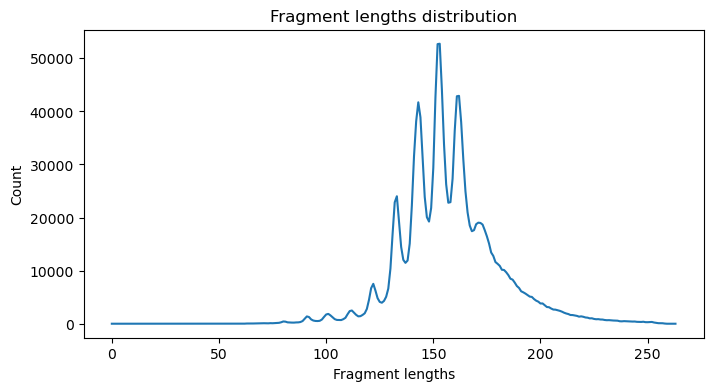

In [125]:
import matplotlib.pyplot as plt

fragment_lengths = result.sum(axis=1)

fig = plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(fragment_lengths)), fragment_lengths)
plt.xlabel("Fragment lengths")
plt.ylabel("Count")
plt.title("Fragment lengths distribution")
plt.show()
fig.savefig('temp.png', dpi=300)


In [79]:
# length vs fragments' relative midpoint
def calculate_coverage(result: np.ndarray, max_position: int) -> np.ndarray:
    coverage = np.zeros(max_position)
    
    for fragment_length in range(result.shape[0]):
        for rel_midpoint in range(result.shape[1]):
            count = result[fragment_length, rel_midpoint]
            if count > 0:
                # calculate start and end positions from midpoint and length
                start_pos = rel_midpoint - fragment_length // 2
                end_pos = rel_midpoint + fragment_length // 2
                
                # make sure we stay in our boundaries
                start_pos = max(0, start_pos)
                end_pos = min(max_position, end_pos)
                
                # update coverage
                if start_pos < end_pos:
                    coverage[start_pos:end_pos] += count
    
    return coverage

coverage = calculate_coverage(result, MATRIX_COLUMNS)
coverage.shape

(2000,)

Text(0.5, 1.0, 'Relative midpoint positions VS Coverage')

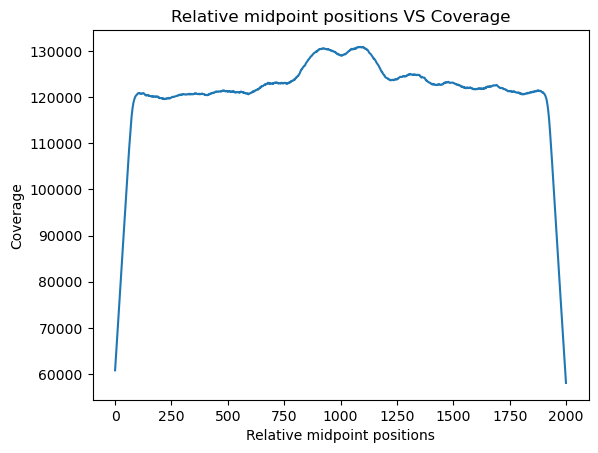

In [103]:
plt.plot(np.arange(len(coverage)), coverage)
plt.xlabel("Relative midpoint positions")
plt.ylabel("Coverage")
plt.title("Relative midpoint positions VS Coverage")

In [109]:
def calculate_lwps(result: np.ndarray, window_size=120) -> np.ndarray:
    num_positions = result.shape[1]
    lwps = np.zeros(num_positions)
    
    # sliding window -> calculating lwps for each positions 1,2,3..,1999,2000
    for pos in range(num_positions):
        if not (pos % 100) or pos == num_positions - 1:
            logger.info("{}%".format(round(pos/num_positions * 100)))
        
        # for position 0 -> window [-60, 60]
        window_start = pos - window_size // 2
        window_end = pos + window_size // 2
        
        # fragments which are outside of this [-60, 60], starts before -60 and ends after 60
        spanning_count = 0
        # fragments those either start or end in the window
        internal_endpoints = 0
        
        for fragment_length in range(result.shape[0]):
            for rel_midpoint in range(result.shape[1]):
                count = result[fragment_length, rel_midpoint]
                if count > 0:
                    # calculate fragment start and end from midpoint and length
                    frag_start = rel_midpoint - fragment_length // 2
                    frag_end = rel_midpoint + fragment_length // 2
                    
                    # count spanning fragments
                    if frag_start <= window_start and frag_end >= window_end:
                        spanning_count += count
                    
                    # count internal endpoints
                    if window_start <= frag_start <= window_end:  # starting in the window
                        internal_endpoints += count
                    if window_start <= frag_end <= window_end:  # ending in the window
                        internal_endpoints += count
        
        lwps[pos] = spanning_count - internal_endpoints
    
    return lwps

lwps = calculate_lwps(result)

INFO:__main__:0%
INFO:__main__:5%
INFO:__main__:10%
INFO:__main__:15%
INFO:__main__:20%
INFO:__main__:25%
INFO:__main__:30%
INFO:__main__:35%
INFO:__main__:40%
INFO:__main__:45%
INFO:__main__:50%
INFO:__main__:55%
INFO:__main__:60%
INFO:__main__:65%
INFO:__main__:70%
INFO:__main__:75%
INFO:__main__:80%
INFO:__main__:85%
INFO:__main__:90%
INFO:__main__:95%
INFO:__main__:100%


Text(0.5, 1.0, 'Relative midpoint positions VS L-WPS score')

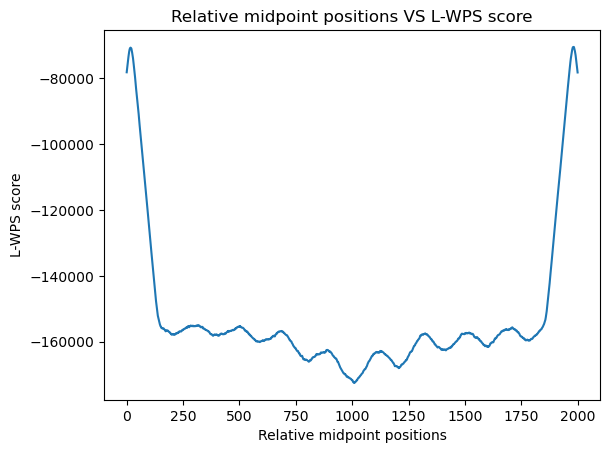

In [110]:
plt.plot(np.arange(len(lwps)), lwps)
plt.xlabel("Relative midpoint positions")
plt.ylabel("L-WPS score")
plt.title("Relative midpoint positions VS L-WPS score")